In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import pandas as pd
import collections
import lqg1d
import json

import numba

# Function definitions

In [40]:
def load_dataframe(folder):
    experiments = []
    for experiment in glob.glob(os.path.join(folder, '*_params.json')):
        with open(experiment, 'r') as f:
            params = json.load(f)

        experiments.append({k.upper():i for k,i in params.items()})
    experiments_df = pd.DataFrame(experiments)
    experiments_df = experiments_df.fillna('-')
    
    return experiments_df

In [41]:
def load_from_dataframe(df):
    return [pd.read_pickle(f + '.gzip') for f in df['FILENAME'].values]
        

In [42]:
def filter_experiments(**kwargs):
    df_filtered = kwargs['df']
    for k,v in kwargs.items():
        if v is not None:
            try:
                if isinstance(v, list):
                    df_filtered = df_filtered[df_filtered[k.upper()].isin(v)]
                else:
                    df_filtered = df_filtered[df_filtered[k.upper()] == v]
            except:
                pass
    return df_filtered

In [43]:
def my_plot(**kwargs):
    data_params = filter_experiments(**kwargs)
    
    free_vars = []
    for k,v in kwargs.items():
        if v is None or (k.upper() in data_params.columns and isinstance(v, list)):
            free_vars.append(k)

    free_vars = [s.upper() for s in free_vars]
    
    if len(free_vars) <= 0:
        data_params = data_params.sort_values(by=list(data_params.columns), ascending=False)
    else:
        data_params = data_params.sort_values(by=free_vars, ascending=False)

    data = load_from_dataframe(data_params)

    plt.rcParams["figure.figsize"] = (15,13)
    
    def plot_lines(**kwargs):
        MAX_T = kwargs['max_t'] if 'max_t' in kwargs else -1
        MIN_T = kwargs['min_t'] if 'min_t' in kwargs else 0
        STEP = kwargs['step'] if 'step' in kwargs else 1
        ALPHA = kwargs['alpha'] if 'alpha' in kwargs else 1

        if isinstance(kwargs['value'], list):
            params = kwargs
            ll = len(kwargs['value'])
            i = 1
            for v in kwargs['value']:
                plt.subplot((ll + 1)//2, 2, i)
                i+=1
                params['value'] = v
                plot_lines(**params)
        else:
            for d in data:
                d['J+J_DET'] = d['J'] + d['J_DET']
                d['J_JOURNEY+J_DET'] = d['J_JOURNEY'] + d['J_DET']
                try:
                    x = d['T'].values[MIN_T:MAX_T:STEP] // STEP
                    y = d[kwargs['value']].values[MIN_T:MAX_T:STEP]
                except:
                    x = d['T'].values[MIN_T:MAX_T:STEP] // STEP
                    y = np.zeros(x.shape[0])
                plt.plot(x, y, alpha=ALPHA)
                plt.xlabel('Timesteps')
                plt.ylabel(kwargs['value'])
                plt.title(kwargs['value'])
                
                if kwargs['value'] == 'J+J_DET':
                    plt.plot(x, [d['J+J_DET'][0]]*len(x), 'r-', label='_nolegend_')
                    print('Initial J+J_DET is: ', d['J+J_DET'][0])
                    print('Average J+J_DET is: ', np.average(d['J+J_DET']))
                if kwargs['value'] == 'J_JOURNEY+J_DET':
                    plt.plot(x, [d['J_JOURNEY+J_DET'][0]]*len(x), 'r-', label='_nolegend_')
                if kwargs['value'] == 'BUDGET':
                    plt.plot(x, [0]*len(x), 'r-', label='_nolegend_')
                    print('Budget is negative for: ', sum(d['BUDGET']<0), '/', d['BUDGET'].shape[0], ' times')
                if kwargs['value'] == 'J_JOURNEY':
                    plt.plot(x, [d['J_JOURNEY'][0]]*len(x), 'r-', label='_nolegend_')
                if kwargs['value'] == 'GRAD_DELTAW':
                    plt.plot(x, [0]*len(x), 'r-', label='_nolegend_')

    plot_lines(**kwargs)
    
    # Build legend

    legend = [' '.join(map(lambda x : ': '.join((x[0], x[1] if x[1] is not np.nan else '-')), zip(data_params.loc[:,free_vars].columns.values, s))) for s in data_params.loc[:,free_vars].values]

    plt.legend(legend, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        

In [44]:
def get_random_seed(x):
    tokens = x.split('_')
    return int(tokens[-1])

In [45]:
def add_learning_rate(x):
    tokens = x.split('_')
    if (tokens[0] == 'Adam') or (tokens[0] == 'MonotonicNaiveGradient'):
        return tokens[1]
    else:
        return '-'

In [46]:
def get_avg_col(column):
    def get_average(x):
        return pd.DataFrame([x[column] for x in load_from_dataframe(x)]).mean().values
    return get_average

In [47]:
def get_std_col(column):
    def get_std(x):
        if column == 'J+J_DET':
            means_j = [x['J'] for x in load_from_dataframe(x)]
            means_jdet = [x['J_DET'] for x in load_from_dataframe(x)]
            return pd.DataFrame(a+b for a,b in zip(means_j, means_jdet)).std().values
        else:
            return pd.DataFrame([x[column] for x in load_from_dataframe(x)]).std().values
    return get_std

In [48]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [49]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{units}')
FIGURE_SIZE = (14,7)
ADJUST_LEFT=0.17
FONT_SIZE=28
LEGEND_SIZE=24

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

In [50]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='b', lw=14),
                Line2D([0], [0], color='m', lw=14),
                Line2D([0], [0], color='orangered', lw=14)]

# Other plots

In [51]:
df = load_dataframe('EXPERIMENTS_FINAL_LONG/')

In [52]:
df['EXPERIMENT'].unique()

array(['ExpBudget_DetPolicy',
       'SimultaneousThetaAndSigma_two_thirds_theta', 'MonotonicOnlyTheta',
       'MonotonicZeroBudgetEveryStep', 'SimultaneousThetaAndSigma_half',
       'ExpBudget_NoDetPolicy', 'MonotonicThetaAndSigma',
       'ExpBudget_SemiDetPolicy', 'NoWorseThanBaselineEveryStep',
       'SimultaneousThetaAndSigma_two_thirds_sigma'], dtype=object)

In [53]:
df['RANDOM_SEED'] = df['NAME'].apply(get_random_seed)

In [54]:
df_small = df[df['RANDOM_SEED'] == 2]

In [55]:
average_J = df.groupby(['EXPERIMENT']).apply(get_avg_col('J'))

In [56]:
std_J = df.groupby(['EXPERIMENT']).apply(get_std_col('J'))

In [57]:
average_sigma = df.groupby(['EXPERIMENT']).apply(get_avg_col('SIGMA'))

In [58]:
std_sigma = df.groupby(['EXPERIMENT']).apply(get_std_col('SIGMA'))

In [59]:
average_theta = df.groupby(['EXPERIMENT']).apply(get_avg_col('THETA'))

In [60]:
std_theta = df.groupby(['EXPERIMENT']).apply(get_std_col('THETA'))

In [61]:
average_jjdet = df.groupby(['EXPERIMENT']).apply(get_avg_col('J')) + df.groupby(['EXPERIMENT']).apply(get_avg_col('J_DET'))

In [62]:
std_jjdet = df.groupby(['EXPERIMENT']).apply(get_std_col('J+J_DET'))

In [63]:
average_jdet = df.groupby(['EXPERIMENT']).apply(get_avg_col('J_DET'))
std_jdet = df.groupby(['EXPERIMENT']).apply(get_std_col('J_DET'))

In [64]:
average_budget = df.groupby(['EXPERIMENT']).apply(get_avg_col('BUDGET'))
std_budget = df.groupby(['EXPERIMENT']).apply(get_std_col('BUDGET'))

## AAAI

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

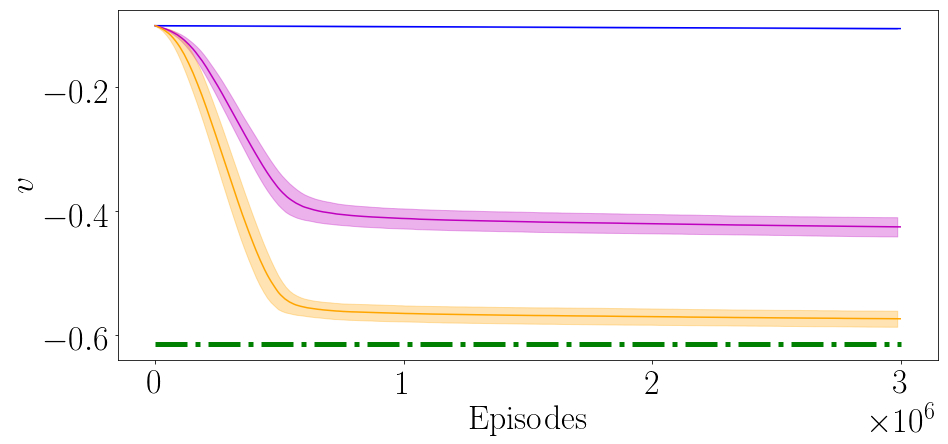

In [65]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

colors = ['b', 'm', 'orange']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['MonotonicThetaAndSigma', 'ExpBudget_NoDetPolicy', 'ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=34)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_theta[name], ma_mean)
    means_stds = moving_average(average_theta[name], ma_var)
    stds = moving_average(std_theta[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-2/np.sqrt(5)*stds)[::step_var], 
                     (means_stds+2/np.sqrt(5)*stds)[::step_var], alpha=0.3, color=c)
#plt.plot([0,300*10000], np.ones(2) * -87.3, 'r--', linewidth=5)
plt.plot([0,300*10000], np.ones(2) * -0.615, 'g-.', linewidth=5)
    
plt.ylabel('$v$')
plt.xlabel('Episodes')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#plt.legend(['MI', 'SEPG', 'SSEPG'], loc=(.6,.5),  prop={'size': 28})
plt.xticks([0, 1e06, 2e06, 3e06])

plt.tight_layout()
plt.savefig('theta.pdf')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

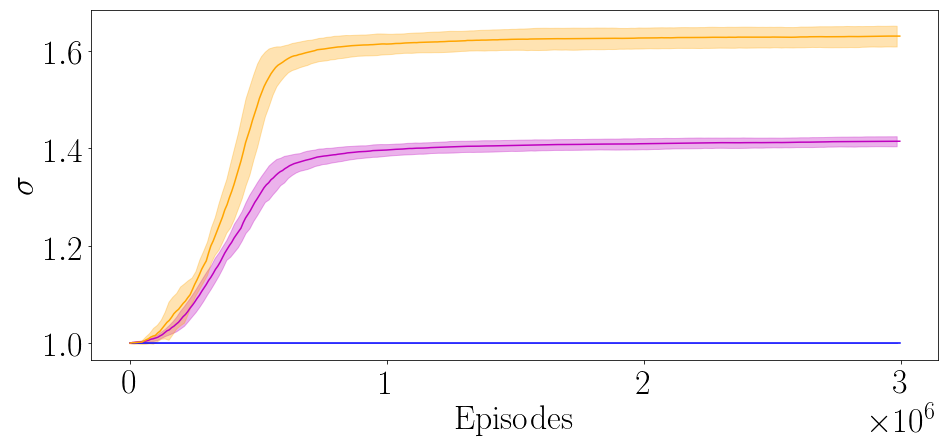

In [66]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

colors = ['b', 'm', 'orange']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['MonotonicThetaAndSigma', 'ExpBudget_NoDetPolicy', 'ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=34)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_sigma[name], ma_mean)
    means_stds = moving_average(average_sigma[name], ma_var)
    stds = moving_average(std_sigma[name], ma_var)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-stds)[::step_var], (means_stds+stds)[::step_var], alpha=0.3, color=c)
#plt.plot([0,300*10000], np.ones(2) * -87.3, 'r--', linewidth=5)
#plt.plot([0,300*10000], np.ones(2) * -0.615, 'g-.', linewidth=5)
    
plt.ylabel('$\\sigma$')
plt.xlabel('Episodes')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.xticks([0, 1e06, 2e06, 3e06])

plt.tight_layout()
plt.savefig('sigma.pdf')

In [67]:
average_J['ExpBudget_NoDetPolicy']

array([-85.93608564, -89.82927293, -88.01161495, ..., -90.00333087,
       -88.03133935, -91.69039949])

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

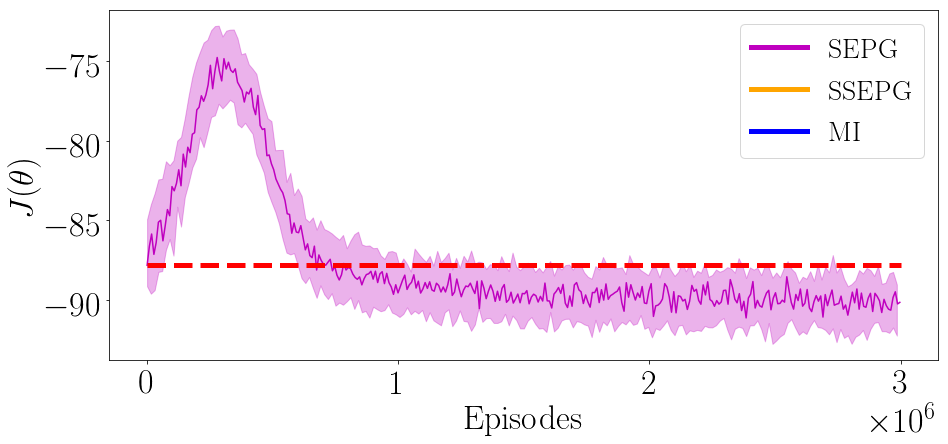

In [68]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

colors = ['m']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['ExpBudget_NoDetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=34)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_J[name], ma_mean)
    means_stds = moving_average(average_J[name], ma_var)
    stds = moving_average(std_J[name], ma_var)
    
    baseline = moving_average(average_J[name][0:ma_mean], ma_mean)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-2/np.sqrt(5)*stds)[::step_var], 
                     (means_stds+2/np.sqrt(5)*stds)[::step_var], alpha=0.3, color=c)

plt.plot([0],[-90],color='orange')
plt.plot([0],[-90],color='b')
plt.plot([0,300*10000], np.ones(2) * baseline, 'r--', linewidth=5)
#plt.plot([0,300*10000], np.ones(2) * -0.615, 'g-.', linewidth=5)
    
plt.ylabel('$J(\\theta)$')
plt.xlabel('Episodes')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#plt.legend(['MI', 'SEPG', 'SSEPG'], loc=(.6,.5),  prop={'size': 28})
plt.xticks([0, 1e06, 2e06, 3e06])

leg = plt.legend(['SEPG', 'SSEPG','MI'], loc=1,  prop={'size': 28})
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)

plt.tight_layout()
plt.savefig('J.pdf')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

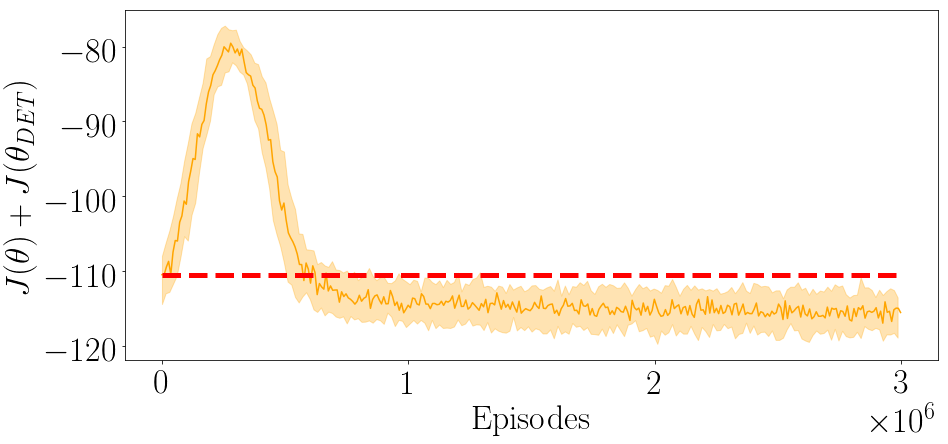

In [69]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

colors = ['orange']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=34)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_jjdet[name], ma_mean)
    means_stds = moving_average(average_jjdet[name], ma_var)
    stds = moving_average(std_jjdet[name], ma_var)
    
    baseline = moving_average(average_jjdet[name][0:ma_mean], ma_mean)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-2/np.sqrt(5)*stds)[::step_var], 
                     (means_stds+2/np.sqrt(5)*stds)[::step_var], alpha=0.3, color=c)


plt.plot([0,300*10000], np.ones(2) * baseline, 'r--', linewidth=5)
#plt.plot([0,300*10000], np.ones(2) * -0.615, 'g-.', linewidth=5)
    
plt.ylabel('$J(\\theta)+J(\\theta_{DET})$')
plt.xlabel('Episodes')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#plt.legend(['MI', 'SEPG', 'SSEPG'], loc=(.6,.5),  prop={'size': 28})
plt.xticks([0, 1e06, 2e06, 3e06])

plt.tight_layout()
plt.savefig('jjdet.pdf')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

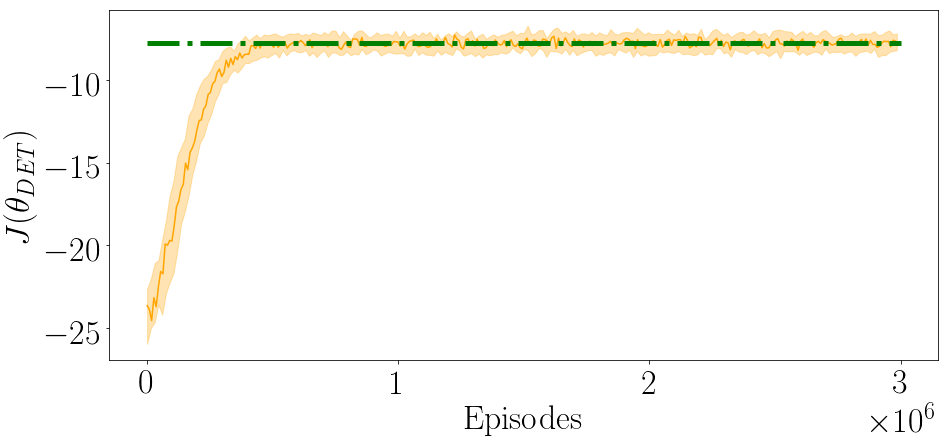

In [70]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

colors = ['orange']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=34)
plt.rc('font',**{'family':'serif','serif':['cm']})
for name,c in zip(algos, colors):
    means = moving_average(average_jdet[name], ma_mean)
    means_stds = moving_average(average_jdet[name], ma_var)
    stds = moving_average(std_jdet[name], ma_var)
    
    baseline = moving_average(average_jdet[name][0:ma_mean], ma_mean)
    
    plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
    plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-2/np.sqrt(5)*stds)[::step_var], 
                     (means_stds+2/np.sqrt(5)*stds)[::step_var], alpha=0.3, color=c)
#plt.plot([0,300*10000], np.ones(2) * baseline, 'r--', linewidth=5)
plt.plot([0,300*10000], np.ones(2) * -7.753, 'g-.', linewidth=5)
    
plt.ylabel('$J(\\theta_{DET})$')
plt.xlabel('Episodes')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#plt.legend(['MI', 'SEPG', 'SSEPG'], loc=(.6,.5),  prop={'size': 28})
plt.xticks([0, 1e06, 2e06, 3e06])

plt.tight_layout()
plt.savefig('jdet.pdf')

# EWRL

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

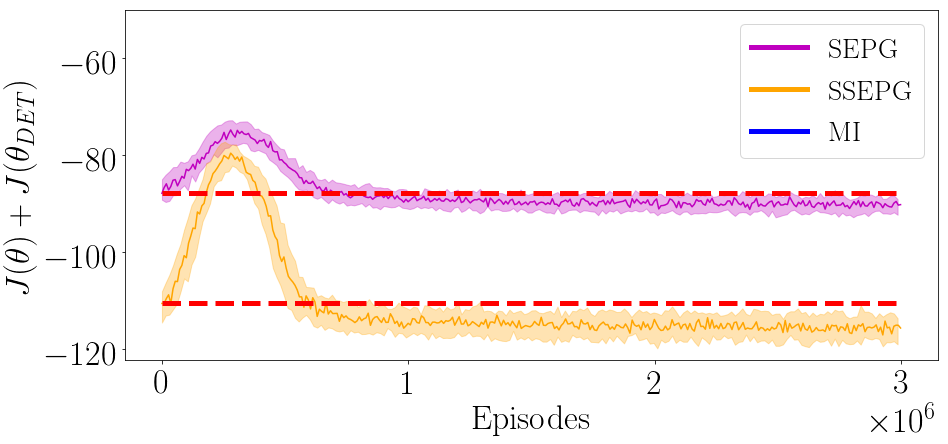

In [102]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)

colors = ['m', 'orange']

step_mean = 30
step_var = 50

ma_mean = 4
ma_var = 10

algos = ['ExpBudget_NoDetPolicy', 'ExpBudget_DetPolicy']
plt.rc('text', usetex=True)
plt.rc('font', size=34)
plt.rc('font',**{'family':'serif','serif':['cm']})

c = 'm'
name = 'ExpBudget_NoDetPolicy'
means = moving_average(average_J[name], ma_mean)
means_stds = moving_average(average_J[name], ma_var)
stds = moving_average(std_J[name], ma_var)
baseline1 = moving_average(average_J[name][0:ma_mean], ma_mean)
plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-2/np.sqrt(5)*stds)[::step_var], 
                     (means_stds+2/np.sqrt(5)*stds)[::step_var], alpha=0.3, color=c)
    
c = 'orange'
name = 'ExpBudget_DetPolicy'
means = moving_average(average_jjdet[name], ma_mean)
means_stds = moving_average(average_jjdet[name], ma_var)
stds = moving_average(std_jjdet[name], ma_var)
baseline2 = moving_average(average_jjdet[name][0:ma_mean], ma_mean)
plt.plot(300*np.arange(len(means))[::step_mean], means[::step_mean], color=c)
plt.fill_between(300*np.arange(len(means_stds))[::step_var],(means_stds-2/np.sqrt(5)*stds)[::step_var], 
                     (means_stds+2/np.sqrt(5)*stds)[::step_var], alpha=0.3, color=c)

plt.plot([0],[-90],color='b')
leg = plt.legend(['SEPG', 'SSEPG','MI'], loc=1,  prop={'size': 28})
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)
    
plt.plot([0,300*10000], np.ones(2) * baseline2, 'r--', linewidth=5)
plt.plot([0,300*10000], np.ones(2) * baseline1, 'r--', linewidth=5)
    
plt.ylabel('$J(\\theta) + J(\\theta_{DET})$')
plt.xlabel('Episodes')
plt.ylim(ymax=-50)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#plt.legend(['MI', 'SEPG', 'SSEPG'], loc=(.6,.5),  prop={'size': 28})
plt.xticks([0, 1e06, 2e06, 3e06])

plt.tight_layout()
plt.savefig('J_jjdet.pdf')

# MOUNTAIN CAR

In [71]:
df = load_dataframe('MC_INITBUDGET')

In [72]:
df

,APPROXIMATE_GRADIENTS,DELTA,EXPERIMENT,FILENAME,GAMMA,MAX_ITER,NAME,N_MAX,N_MIN,N_TOT,PARALLEL,SIGMA,THETA_0,THETA_1,USE_LOCAL_STATS,VERBOSE
0,True,0.9,ExpBudget_DetPolicy,MC_INITBUDGET/Det_0.2_1iK2ZWeqhFWCEPyY,0.99,15000,Det_0.2_1,500000,100,30000000,True,0.6,0.0,0.0,True,True
1,True,0.9,ExpBudget_DetPolicy,MC_INITBUDGET/Det_0.2_1_NODISCOUNTiK2ZWeqhFWCEPyY,0.99,15000,Det_0.2_1_NODISCOUNT,500000,100,30000000,True,0.2,0.0,0.0,True,True
2,True,0.9,Adam,MC_INITBUDGET/Adam_0.1_1iK2ZWeqhFWCEPyY,0.99,15000,Adam_0.1_1,500000,100,30000000,True,0.2,0.0,0.0,True,True
3,True,0.9,Adam,MC_INITBUDGET/Adam_0.0001_1iK2ZWeqhFWCEPyY,0.99,15000,Adam_0.0001_1,500000,100,30000000,True,0.2,0.0,0.0,True,True
4,True,0.9,ExpBudget_DetPolicy,MC_INITBUDGET/Det_0.2_budget10iK2ZWeqhFWCEPyY,0.99,15000,Det_0.2_budget10,500000,100,30000000,True,0.2,0.0,0.0,True,True
5,True,0.9,MonotonicNaiveGradient,MC_INITBUDGET/Naive_0.0001_1iK2ZWeqhFWCEPyY,0.99,15000,Naive_0.0001_1,500000,100,30000000,True,0.2,0.0,0.0,True,True
6,True,0.9,Adam,MC_INITBUDGET/Adam_0.1iK2ZWeqhFWCEPyY,0.99,15000,Adam_0.1,500000,100,30000000,True,0.2,0.0,0.0,True,True


/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

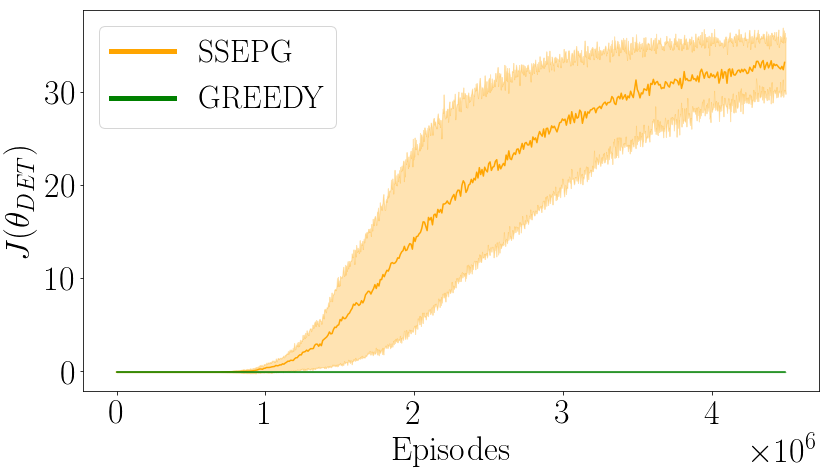

In [73]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)


colors = ['green', 'orange']

varname = 'J_DET'

step = 10

c = 'orange'
df = load_dataframe('EXP/')
dfs = load_from_dataframe(filter_experiments(df=df, name=['mcDet1', 'mcDet2', 'mcDet3', 'mcDet4', 'mcDet5']))
df_concat = pd.concat(dfs)
df_group = df_concat.groupby(df_concat.index)
df_mean = df_group.mean()
df_std = df_group.std()
xfinalmean = 300*df_mean['T'][::step_mean]
plt.plot(xfinalmean, df_mean[::step_mean][varname],color=c)
plt.fill_between(300*np.arange(len(df_mean))[::step],(df_mean[varname]-2/np.sqrt(5)*df_std[varname])[::step],
                 (df_mean[varname]+2/np.sqrt(5)*df_std[varname])[::step], alpha=0.3, color=c)

c = 'green'
df = load_dataframe('GREEDY/')
dfs = load_from_dataframe(filter_experiments(df=df, name=['mcGreedy1', 'mcGreedy2', 'mcGreedy3', 'mcGreedy4', 'mcGreedy5']))
df_concat = pd.concat(dfs)
df_group = df_concat.groupby(df_concat.index)
df_mean = df_group.mean()
df_std = df_group.std()
xfinalmean = 300*df_mean['T'][::step_mean]
plt.plot(xfinalmean, df_mean[::step_mean][varname],color=c)
plt.fill_between(300*np.arange(len(df_mean))[::step],(df_mean[varname]-2/np.sqrt(5)*df_std[varname])[::step],
                 (df_mean[varname]+2/np.sqrt(5)*df_std[varname])[::step], alpha=0.3, color=c)

plt.rc('text', usetex=True)
plt.rc('font', size=FONT_SIZE)
plt.rc('font',**{'family':'serif','serif':['cm']})
    
    
plt.ylabel(r'$J(\theta_{DET})$')
plt.xlabel('Episodes')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
leg = plt.legend(['SSEPG','GREEDY'], prop={'size': 1.3*LEGEND_SIZE})
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)

plt.xticks([0, 1e06, 2e06, 3e06, 4e06])


plt.savefig('mc1.pdf',  bbox_inches='tight')

/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/matteo/miniconda2/envs/py3/lib/python3.6/site-packages/matplotlib/font_man

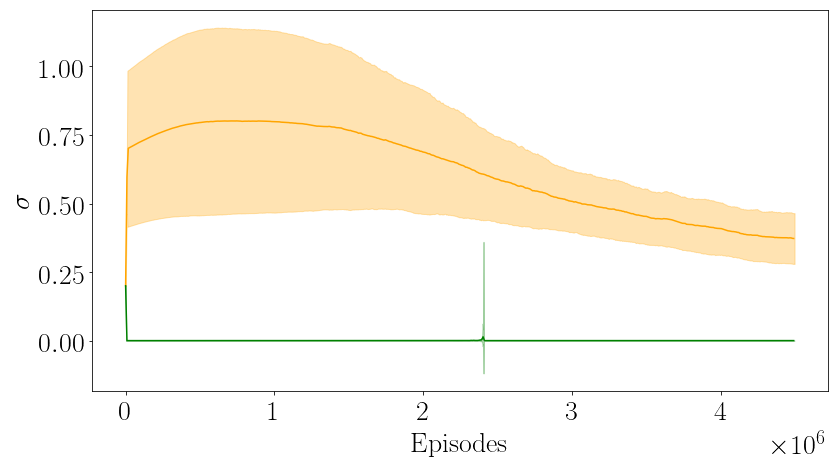

In [74]:
plt.figure(figsize=FIGURE_SIZE)
plt.tight_layout()
plt.gcf().subplots_adjust(left=ADJUST_LEFT)


colors = ['green', 'orange']

varname = 'SIGMA'

step = 10

c = 'orange'
df = load_dataframe('EXP/')
dfs = load_from_dataframe(filter_experiments(df=df, name=['mcDet1', 'mcDet2', 'mcDet3', 'mcDet4', 'mcDet5']))
df_concat = pd.concat(dfs)
df_group = df_concat.groupby(df_concat.index)
df_mean = df_group.mean()
df_std = df_group.std()
xfinalmean = 300*df_mean['T'][::step_mean]
plt.plot(xfinalmean, df_mean[::step_mean][varname],color=c)
plt.fill_between(300*np.arange(len(df_mean))[::step],(df_mean[varname]-2/np.sqrt(5)*df_std[varname])[::step], 
                 (df_mean[varname]+2/np.sqrt(5)*df_std[varname])[::step], alpha=0.3, color=c)

c = 'green'
df = load_dataframe('GREEDY/')
dfs = load_from_dataframe(filter_experiments(df=df, name=['mcGreedy1', 'mcGreedy2', 'mcGreedy3', 'mcGreedy4', 'mcGreedy5']))
df_concat = pd.concat(dfs)
df_group = df_concat.groupby(df_concat.index)
df_mean = df_group.mean()
df_std = df_group.std()
xfinalmean = 300*df_mean['T'][::step_mean]
plt.plot(xfinalmean, df_mean[::step_mean][varname],color=c)
plt.fill_between(300*np.arange(len(df_mean))[::step],(df_mean[varname]-2/np.sqrt(5)*df_std[varname])[::step], 
                 (df_mean[varname]+2/np.sqrt(5)*df_std[varname])[::step], alpha=0.3, color=c)

plt.rc('text', usetex=True)
plt.rc('font', size=FONT_SIZE)
plt.rc('font',**{'family':'serif','serif':['cm']})
    
    
plt.ylabel(r'$\sigma$')
plt.xlabel('Episodes')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#leg = plt.legend(['SSEPG','GREEDY'], prop={'size': 1.3*LEGEND_SIZE})
#for legobj in leg.legendHandles:
#    legobj.set_linewidth(5.0)

plt.xticks([0, 1e06, 2e06, 3e06, 4e06])


plt.savefig('mc2.pdf',  bbox_inches='tight')